# k-means with text data

In this assignment we will
  - Cluster Wikipedia documents using k-means
  - Explore the role of random initialization on the quality of the clustering
  - Explore how results differ after changing the number of clusters
  - Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

**Note to Amazon EC2 users**: To conserve memory, make sure to stop all the other notebooks before running this notebook.

## Import necessary packages

In [1]:
import turicreate
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%matplotlib inline

## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first assignment, let's extract TF-IDF features for each article.

In [2]:
wiki = turicreate.SFrame('../data/people_wiki.sframe/')

In [3]:
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['text'])
wiki.column_names(), wiki.shape

(['URI', 'name', 'text', 'tf_idf'], (59071, 4))

For the remainder of the assignment, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

In [4]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert type(x[column_name][0]) == dict, 'The chosen column must be dict type, representing sparse data.'

    x = x.add_row_number()                          ## 1. Add a row number (id)
    x = x.stack(column_name, ['feature', 'value'])  ## 2. Stack will transform x to have a row for each unique (row, key) pair.
    mapping = {                                     ## 3. Map feature words to integers 
      word:i for i, word in enumerate(sorted(x['feature'].unique()))
    }
    x['feature_id'] = x['feature'].apply(lambda x: mapping[x])

    d = {}
    for key in ['id', 'feature_id', 'value']:       ## 4. Create numpy arrays that contain the data for the sparse matrix.
      d[key] = np.array(x[key])

    width,  height = x['id'].max() + 1, x['feature_id'].max() + 1    
    mat = csr_matrix((d['value'], (d['id'], d['feature_id'])),   
                     shape=(width, height))         ## 5. Create a sparse matrix.
    return mat, mapping

In [5]:
%%time
# The conversion will take about a minute or two.
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

CPU times: user 2min 5s, sys: 3.03 s, total: 2min 8s
Wall time: 27.3 s


The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

In [6]:
tf_idf.shape

(59071, 547979)

## Normalize all vectors

As discussed in the previous assignment, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [7]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [8]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: np.random.seed(seed)  ## useful for obtaining consistent results
      
    n = data.shape[0]                          ## number of data points
    rand_indices = np.random.randint(0, n, k)  ## Pick K indices from range [0, n).
     
    ## Keep centroids as dense format, as many entries will be nonzero due to averaging.
    ## As long as at least one document in a cluster contains a word,
    ## it will carry a nonzero weight in the TF-IDF vector of the centroid.
    return data[rand_indices, :].toarray()

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_assignment = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_assignment)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? <br />
First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. <br />
In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [9]:
from sklearn.metrics import pairwise_distances

queries = tf_idf[100:102, :]                                   ## Get the TF-IDF vectors for documents 100 through 102.
dist = pairwise_distances(tf_idf, queries, metric='euclidean') ## Compute pairwise distances from every data point to each query vector.
dist

array([[1.41000789, 1.36894636],
       [1.40935215, 1.41023886],
       [1.39855967, 1.40890299],
       ...,
       [1.41108296, 1.39123646],
       [1.41022804, 1.31468652],
       [1.39899784, 1.41072448]])

More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i, :]`) and the `j`th row of `Y` (i.e., `Y[j, :]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. <br />
Write code to compute distances from each of the centroids to all data points in `tf_idf`. <br />
Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [10]:
## Students should write code here
centroids3 = tf_idf[0:3, :]                                          ## 0, 1 and 2
dist3 = pairwise_distances(tf_idf, centroids3, metric='euclidean')   ## pairwise distance between all data points and our 3 selected centroids
dist = dist3[430][1]                                                 ## dist row 430, 2nd centrois (centroids3[1])

In [11]:
'''Test cell'''
assert np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:]))

**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `dist3`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

**Hint:** the resulting array should be as long as the number of data points.

In [12]:
## Students should write code here
closest_cluster = np.argmin(dist3, axis=1)
assert len(closest_cluster) == len(dist3)    ## len(dist3) == 59071

In [13]:
'''Test cell'''
reference = [list(r).index(min(r)) for r in dist3]
assert np.allclose(closest_cluster, reference)

**Checkpoint:** Let's put these steps together.  
  - first, initialize three centroids with the first 3 rows of `tf_idf` / DONE
  - compute distances from each of the centroids to all data points in `tf_idf` / DONE 
  - finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment` / DONE => just renaming!

In [14]:
## Students should write code here
cluster_assignment = closest_cluster

In [15]:
assert len(cluster_assignment) == 59071 and \
np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])) #:

Now we are ready to fill in the blanks in this function:

In [16]:
def assign_clusters(data, centroids):
    ## Compute distances between each data point and the set of centroids:
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    ## Compute cluster assignments for each data point:
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    return cluster_assignment

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [17]:
assert np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), 
                   np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))

### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster assignments. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_assignment==0, :]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [18]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])

centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [19]:
cluster_assignment = assign_clusters(data, centroids)
cluster_assignment  # 1st data point(dp) to 1st cluster, 2nd dp to 2nd and 3rd fp to 1st cluster

array([0, 1, 0])

The expression `cluster_assignment==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not <br />
And likewise for cluster 0:

In [20]:
cluster_assignment == 1, cluster_assignment == 0

(array([False,  True, False]), array([ True, False,  True]))

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [21]:
data[cluster_assignment == 1]

array([[0., 0., 0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [22]:
data[cluster_assignment == 0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [23]:
data[cluster_assignment == 0].mean(axis=0)  #  mean over cols, hence axis=0

array([1.5, 2. , 0. ])

We are now ready to complete this function:

In [24]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for ix in range(k):
        member_data_points = data[cluster_assignment == ix]     ## 1. Select all data points that belong to cluster ix
        centroid = data[cluster_assignment == ix].mean(axis=0)  ## 2. Compute the mean of the data points.
        centroid = centroid.A1                                  ## 3. Convert numpy.matrix type to numpy.ndarray type
        new_centroids.append(centroid)
    #
    return np.array(new_centroids)

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [25]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))

assert np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0))

### Assessing convergence

How can we tell if the k-means algorithm is converging? <br />
We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. <br />
To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: *the sum of all squared distances between data points and centroids*. <br />
This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [26]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    heterogeneity = 0.0
    for ix in range(k):
        member_dpts = data[cluster_assignment == ix, :]   ## Select all data points that belong to cluster ix
        if member_dpts.shape[0] > 0:                      ## check if i-th cluster is non-empty
            distances = pairwise_distances(member_dpts,   ## Compute distances from centroid to data points
                                           [centroids[ix]], metric='euclidean')
            heterogeneity += np.sum(distances ** 2)
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster assignments and centroids.

In [27]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [28]:
# Fill in the blanks
def kmeans(data, k, init_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = init_centroids[:]
    prev_cluster_assign = None
    for itr in range(maxiter):        
        if verbose: print(itr, end=' ')
        
        cluster_assign = assign_clusters(data, centroids)       ## 1. Make cluster assignments using nearest centroids
        centroids = revise_centroids(data, k, cluster_assign)   ## 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        if prev_cluster_assign is not None and \
          (prev_cluster_assign == cluster_assign).all():        ## 3. Check for convergence: if none of the assignments changed, stop
            break                                             

        if prev_cluster_assign is not None:                     ## 4. Print number of new assignments 
            num_changed = np.sum(prev_cluster_assign != cluster_assign)
            if verbose: print(f'\t{num_changed:5d} elements changed their cluster assignment.')
        
        if record_heterogeneity is not None:                    ## 5. Record heterogeneity convergence metric
            score = compute_heterogeneity(data, k, centroids, cluster_assign)
            record_heterogeneity.append(score)
        
        prev_cluster_assign = cluster_assign[:]                 ## Copy (and not a ref.)
    #    
    return centroids, cluster_assign

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [29]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

In [30]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)


0 1 	19157 elements changed their cluster assignment.
2 	 7739 elements changed their cluster assignment.
3 	 5119 elements changed their cluster assignment.
4 	 3370 elements changed their cluster assignment.
5 	 2811 elements changed their cluster assignment.
6 	 3233 elements changed their cluster assignment.
7 	 3815 elements changed their cluster assignment.
8 	 3172 elements changed their cluster assignment.
9 	 1149 elements changed their cluster assignment.
10 	  498 elements changed their cluster assignment.
11 	  265 elements changed their cluster assignment.
12 	  149 elements changed their cluster assignment.
13 	  100 elements changed their cluster assignment.
14 	   76 elements changed their cluster assignment.
15 	   67 elements changed their cluster assignment.
16 	   51 elements changed their cluster assignment.
17 	   47 elements changed their cluster assignment.
18 	   40 elements changed their cluster assignment.
19 	   34 elements changed their cluster assignment.


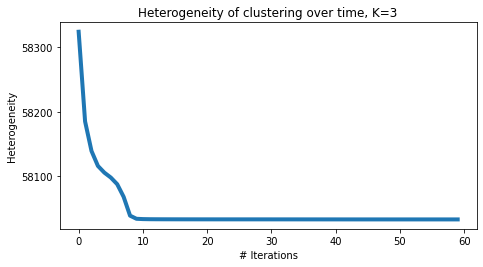

In [31]:
plot_heterogeneity(heterogeneity, k)

In [32]:
centroids, cluster_assignment, len(centroids), len(cluster_assignment)

(array([[5.87110231e-05, 1.31110010e-05, 7.99378431e-05, ...,
         4.92760843e-06, 4.65411605e-06, 0.00000000e+00],
        [5.14216584e-04, 4.12735366e-04, 1.34328522e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.31599344e-05, 1.70980163e-05, 6.56023275e-05, ...,
         0.00000000e+00, 7.08812731e-06, 3.78271853e-06]]),
 array([1, 2, 0, ..., 1, 1, 2]),
 3,
 59071)

In [33]:
for ix in range(3):
  ndp = np.sum(cluster_assignment == ix)
  print(f"cluster {ix:2d} has {ndp} data points")  
## equiv. np.bincount(...)

cluster  0 has 19595 data points
cluster  1 has 10427 data points
cluster  2 has 29049 data points


**Quiz Question**. (True/False) The clustering objective (heterogeneity) is non-increasing for this example.
  - True

**Quiz Question**. Let's step back from this particular example. If the clustering objective (heterogeneity) would ever increase when running k-means, that would indicate: (choose one)

  1. [ ] k-means algorithm got stuck in a bad local minimum
  2. [x] There is a bug in the k-means code
  3. [ ] All data points consist of exact duplicates
  4. [ ] Nothing is wrong. The objective should generally go down sooner or later.

**Quiz Question**. Which of the cluster contains the greatest number of data points in the end? Hint: Use [`np.bincount()`](http://docs.scipy.org/doc/numpy-1.11.0/reference/generated/numpy.bincount.html) to count occurrences of each cluster label.
  1. [ ] Cluster #0
  2. [ ] Cluster #1
  3. [x] Cluster #2  
     cf. cell below.

In [34]:
clu_cnt = np.bincount(cluster_assignment)
cluster_assignment, clu_cnt, np.argmax(clu_cnt)

(array([1, 2, 0, ..., 1, 1, 2]), array([19595, 10427, 29049]), 2)

## Beware of local maxima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

This may take several minutes to run.

In [35]:
import time

def run_kmeans_with_multi_seeds(tf_idf, k=10, init='random'):
  heterogeneity = {}
  cluster_assign_h = {}
  start = time.time()
  m_ix_largest_clu, m_larg_clu_sz = -1, -1
  
  for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    init_centroids = get_initial_centroids(tf_idf, k, seed) if init == 'random' \
      else smart_initialize(tf_idf, k, seed)
    centroids, cluster_assign = kmeans(tf_idf, k, init_centroids, maxiter=400,
                                       record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assign)
    cluster_assign_h[seed] = np.bincount(cluster_assign)
    ix_larg_clu = np.argmax(cluster_assign_h[seed])
    larg_clu_sz = cluster_assign_h[seed][ix_larg_clu]
    print(f'{time.time() - start:3.3f}sec.  seed={seed:6d}, heterogeneity={heterogeneity[seed]:.5f} ', 
          f'cluster_distribution={cluster_assign_h[seed]} / largest cluster: {ix_larg_clu} size: {larg_clu_sz}')
    if larg_clu_sz > m_larg_clu_sz:
       m_ix_largest_clu, m_larg_clu_sz = ix_larg_clu, larg_clu_sz
    # sys.stdout.flush()
  print(f"took: {time.time() - start:3.3f} sec.")
  return (cluster_assign_h, heterogeneity)

In [36]:
cluster_assign_wri,  heterogeneity_wri = run_kmeans_with_multi_seeds(tf_idf)  ## with random init

13.990sec.  seed=     0, heterogeneity=57457.52442  cluster_distribution=[18047  3824  5671  6983  1492  1730  3882  3449  7139  6854] / largest cluster: 0 size: 18047
25.351sec.  seed= 20000, heterogeneity=57533.20100  cluster_distribution=[ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485] / largest cluster: 4 size: 15779
35.947sec.  seed= 40000, heterogeneity=57512.69257  cluster_distribution=[ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132] / largest cluster: 9 size: 18132
44.969sec.  seed= 60000, heterogeneity=57466.97925  cluster_distribution=[ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900] / largest cluster: 9 size: 17900
75.320sec.  seed= 80000, heterogeneity=57494.92990  cluster_distribution=[17582  1785  7215  3314  6285   809  5930  6791  5536  3824] / largest cluster: 0 size: 17582
85.091sec.  seed=100000, heterogeneity=57484.42210  cluster_distribution=[ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387] / largest cluster: 4 size

Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

**Quiz Question**. Another way to capture the effect of changing initialization is to look at the distribution of cluster assignments. <br />
   - Add a line to the code above to compute the size (# of member data points) of clusters for each run of k-means. 
   - Look at the size of the largest cluster (most # of member data points) across multiple runs, with seeds 0, 20000, ..., 120000. 
  
  How much does this measure vary across the runs? What is the minimum and maximum values this quantity takes?
   -  cf. cell above => 18132

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. <br />
This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the *quality of local optima* and *lower average runtime*.

In [37]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    idx = np.random.randint(data.shape[0])               ## Randomly choose the first centroid. Since we have no prior knowledge, choose uniformly at random
    centroids[0] = data[idx, :].toarray()
    squared_distances = pairwise_distances(data,         ## Compute distances from the first centroid chosen to all the other data points
                                           centroids[0:1], 
                                           metric='euclidean').flatten() ** 2
    for ix in range(1, k):
        ## Choose the next centroid randomly, so that the probability for each data point to be chosen
        ## is directly proportional to its squared distance from the nearest centroid.
        ## Roughtly speaking, a new centroid should be as far as from other centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances / sum(squared_distances))
        centroids[ix] = data[idx, :].toarray()
        ## Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:ix + 1], 
                                                      metric='euclidean') ** 2, axis=1)
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [38]:
cluster_assign_wsi, heterogeneity_wsi = run_kmeans_with_multi_seeds(tf_idf, init='smart')  ## with smart init (wsi)

22.080sec.  seed=     0, heterogeneity=57468.63808  cluster_distribution=[19618  3857  4173  5219  1743  6900  5530  1348  4384  6299] / largest cluster: 0 size: 19618
41.227sec.  seed= 20000, heterogeneity=57486.94263  cluster_distribution=[ 7132  1726  7419 20581  1941  5121  3777  3741   776  6857] / largest cluster: 3 size: 20581
50.688sec.  seed= 40000, heterogeneity=57454.35926  cluster_distribution=[17602  3415  3535  1736  6445  2552  7106  7155   599  8926] / largest cluster: 0 size: 17602
63.837sec.  seed= 60000, heterogeneity=57530.43659  cluster_distribution=[ 2655  9080  8047  2751 16942  1163  2810  6788  3389  5446] / largest cluster: 4 size: 16942
83.021sec.  seed= 80000, heterogeneity=57454.51852  cluster_distribution=[ 6222  2024  6461  6765  5538 18352  3936  1563  1751  6459] / largest cluster: 5 size: 18352
105.661sec.  seed=100000, heterogeneity=57471.56674  cluster_distribution=[ 6459  5477  5746 17792  3436  1346  1743  3792  8075  5205] / largest cluster: 3 siz

Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

In [39]:
def box_plot(heterogeneity_wri, heterogeneity_wsi):
  plt.figure(figsize=(8, 5))
  plt.boxplot([list(heterogeneity_wri.values()), list(heterogeneity_wsi.values())], vert=False)
  plt.yticks([1, 2], ['k-means', 'k-means++'])
  plt.rcParams.update({'font.size': 16})
  plt.tight_layout()

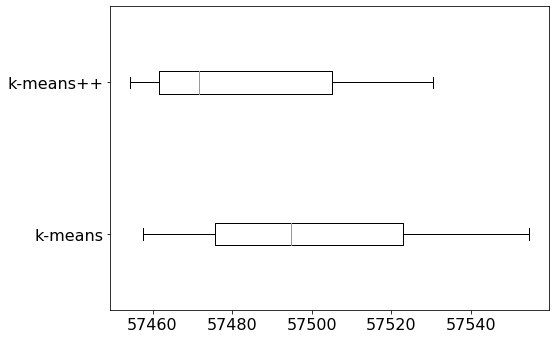

In [40]:
box_plot(heterogeneity_wri, heterogeneity_wsi)

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [41]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    min_heterogeneity_achieved = float('inf')
    best_seed, final_centroids, final_cluster_assign= None, None, None
    
    start = time.time()
    for ix in range(num_runs):
        if seed_list is not None:                         ## Use UTC time if no seeds are provided  
            seed = seed_list[ix]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
    
        init_centroids = smart_initialize(data, k, seed)  ## Use k-means++ initialization
        centroids, cluster_assign = kmeans(data, k,       ## Run k-means
                                           init_centroids, maxiter=maxiter,
                                           record_heterogeneity=None, verbose=False)
        
        ## To save time, compute heterogeneity only once in the end
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assign)
        
        if verbose: print(f'{(time.time() - start):3.3f}sec. / k:{k} / seed={seed:6d}, heterogeneity={heterogeneity[seed]:.5f}')
        # sys.stdout.flush()
        
        ## if current measurement of heterogeneity is lower than previously seen,
        ## update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assign = cluster_assign
    
    if verbose: print(f"\ttook: {(time.time() - start):3.3f} sec.\n\n")
    ## Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assign

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. <br />
*Note: Not all runs for larger K will result in lower heterogeneity than a single run with smaller K due to local optima.* <br />  
Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K. <br />
For each K, use k-means++ and multiple runs to pick the best solution.  <br />
In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about 10 minutes to finish**

In order to speed up the computations, we run them with only one random seed, but for better performance, one should use more seeds and compare the results. If you don't mind running the code for approximately one hour, feel free to uncomment the following line of code below:

`seed_list = [0]#, 20000, 40000, 60000, 80000, 100000, 120000]`

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [42]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7, 4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [43]:
%%time
import numpy as np 

centroids = {}
cluster_assignment = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]
# seed_list = [0]
## Uncomment the following line to run the plot with all the seeds (it may take about an hour to finish).
seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_assignment[k] = kmeans_multiple_runs(tf_idf, k, 
                                                               maxiter=400,
                                                               num_runs=len(seed_list),
                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
    heterogeneity_values.append(score)

3.958sec. / k:2 / seed=     0, heterogeneity=58224.59913
9.939sec. / k:2 / seed= 20000, heterogeneity=58179.57453
15.070sec. / k:2 / seed= 40000, heterogeneity=58179.57453
21.072sec. / k:2 / seed= 60000, heterogeneity=58179.57453
32.036sec. / k:2 / seed= 80000, heterogeneity=58224.59952
37.525sec. / k:2 / seed=100000, heterogeneity=58179.57453
43.016sec. / k:2 / seed=120000, heterogeneity=58179.57453
	took: 43.016 sec.


20.943sec. / k:10 / seed=     0, heterogeneity=57468.63808
39.901sec. / k:10 / seed= 20000, heterogeneity=57486.94263
48.657sec. / k:10 / seed= 40000, heterogeneity=57454.35926
61.721sec. / k:10 / seed= 60000, heterogeneity=57530.43659
79.798sec. / k:10 / seed= 80000, heterogeneity=57454.51852
102.482sec. / k:10 / seed=100000, heterogeneity=57471.56674
117.960sec. / k:10 / seed=120000, heterogeneity=57523.28839
	took: 117.960 sec.


27.886sec. / k:25 / seed=     0, heterogeneity=56913.24052
64.933sec. / k:25 / seed= 20000, heterogeneity=56961.01793
100.109sec. / k:25 /

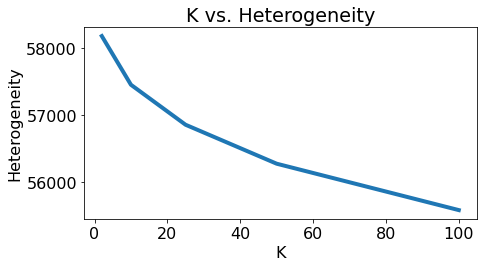

In [44]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** <br />As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. 
At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [45]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assign, k, map_word_to_index, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    map_index_to_word =  {v:k for k,v in map_word_to_index.items()}
    print('==========================================================')
    
    for c in range(k):                        ## Visualize each cluster c
        print('Cluster {0:d}    '.format(c))  ## Cluster heading
        idx = centroids[c].argsort()[::-1]    ## Print top 5 words with largest TF-IDF weights in the cluster
        for ix in range(5):                   ## Print each word along with the TF-IDF weight
            print(f'{map_index_to_word[idx[ix]]:s}:{centroids[c][idx[ix]]:.3f}')
        print('')
        
        if display_content:
            ## Compute distances from the centroid to all data points in the cluster,
            ## and compute nearest neighbors of the centroids within the cluster.
            dists = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            dists[cluster_assign != c] = float('inf')   ## remove non-members from consideration
            nearest_neighbors = dists.argsort()
            
            ## For 8 nearest neighbors, print the title as well as first 180 characters of text.
            ## Wrap the text at 80-character mark.
            for ix in range(8):
                text = ' '.join(wiki[nearest_neighbors[ix]]['text'].split(None, 25)[0:25])
                name = wiki[nearest_neighbors[ix]]['name']
                print(f'\n* {name:50s} {dists[nearest_neighbors[ix]]:.5f}\n  {text[:90]:s}\n  {text[90:]:s}')
        print('==========================================================')
    return

Let us first look at the 2 cluster case (K=2).

In [46]:
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, map_index_to_word)

Cluster 0    
she:0.025
her:0.017
music:0.012
he:0.011
university:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda                         

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: academia, law
* Cluster 1: female figures, baseball players

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-atheletes into more categories. So let us use more clusters. How about `K=10`?

In [47]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, map_index_to_word)

Cluster 0    
film:0.020
art:0.014
he:0.011
book:0.010
television:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823
  paul swadel is a new


* Francis Gavin                                      0.96323
  francis j gavin is first frank stanton chair in nuclear security policy studies and profes
  sor of political science at mit before joining mit he was

* Catherine Hakim                                    0.96374
  catherine hakim born 30 may 1948 is a british sociologist who specialises in womens employ
  ment and womens issues she is currently a professorial research fellow

* Stephen Park Turner                                0.96405
  stephen turner is a researcher in social practice social and political theory and the phil
  osophy of the social sciences he is graduate research professor in

* Robert Bates (political scientist)                 0.96489
  robert hinrichs bates born 1942 is an american political scientist he is eaton professor o
  f the science of government in the departments of government and

* Georg von Krogh                                    0.96505
  georg von krogh was born in oslo norway he is a


* Steven King (ice hockey)                           0.86129
  steven andrew king born july 22 1969 in east greenwich rhode island is a former ice hockey
   forward who played professionally from 1991 to 2000

* Don Jackson (ice hockey)                           0.86661
  donald clinton jackson born september 2 1956 in minneapolis minnesota and bloomington minn
  esota is an ice hockey coach and a retired professional ice hockey player
Cluster 9    
party:0.028
election:0.025
minister:0.025
served:0.021
law:0.019


* Doug Lewis                                         0.96516
  douglas grinslade doug lewis pc qc born april 17 1938 is a former canadian politician a ch
  artered accountant and lawyer by training lewis entered the

* David Anderson (British Columbia politician)       0.96530
  david a anderson pc oc born august 16 1937 in victoria british columbia is a former canadi
  an cabinet minister educated at victoria college in victoria

* Lucienne Robillard                       

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, book, him/his
* Cluster 1: film, theatre, films, tv, actor 
* Cluster 2: baseball players
* Cluster 3: elections, ministers
* Cluster 4: music, orchestra, symphony 
* Cluster 5: female figures from various fields
* Cluster 6: composers, songwriters, singers, music producers
* Cluster 7: law, courts, justice 
* Cluster 8: football 
* Cluster 9: academia

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [ ]:
# cluster 0 = films/art/television?
# cluster 1 = sport/rugby
# cluster 2 = sport/champoinship
# cluster 3 = baseball/league
# cluster 4 = research/university/professor
# cluster 5 = football/basketball
# cluster 6 = actress/films
# cluster 7 = music/album
# cluster 8 = hockey/nhl
# cluster 9 = politics

In [48]:
np.bincount(cluster_assignment[10])

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926])

**Quiz Question**. Which of the 10 clusters above contains the greatest number of articles?

  1. [x] Cluster 0: artists, book, him/his
  1. [ ] Cluster 4: music, orchestra, symphony 
  1. [ ] Cluster 5: female figures from various fields
  1. [ ] Cluster 7: law, courts, justice 
  1. [ ] Cluster 9: academia

**Quiz Question**. Which of the 10 clusters contains the least number of articles?
  cluster 7 not present in my results => means 0?
  
  1. [ ]  Cluster 1: film, theatre, films, tv, actor 
  1. [ ]  Cluster 3: elections, ministers
  1. [ ]  Cluster 6: composers, songwriters, singers, music producers
  1. [x]  Cluster 7: law, courts, justice 
  1. [ ]  Cluster 8: football 

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. <br /> 
For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [49]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
law:0.077
district:0.048
court:0.046
republican:0.038
senate:0.038

Cluster 1    
research:0.054
professor:0.033
science:0.032
university:0.031
physics:0.029

Cluster 2    
hockey:0.216
nhl:0.134
ice:0.065
season:0.052
league:0.047

Cluster 3    
party:0.065
election:0.042
elected:0.031
parliament:0.027
member:0.023

Cluster 4    
board:0.025
president:0.023
chairman:0.022
business:0.022
executive:0.020

Cluster 5    
minister:0.160
prime:0.056
cabinet:0.044
party:0.043
election:0.042

Cluster 6    
university:0.044
professor:0.037
studies:0.035
history:0.034
philosophy:0.031

Cluster 7    
election:0.066
manitoba:0.058
liberal:0.051
party:0.045
riding:0.043

Cluster 8    
racing:0.095
formula:0.056
championship:0.054
race:0.052
poker:0.051

Cluster 9    
economics:0.146
economic:0.096
economist:0.053
policy:0.048
research:0.043

Cluster 10    
championships:0.075
olympics:0.050
marathon:0.048
metres:0.048
she:0.048

Cluster 11    
she:0.144
her:0.092
miss:0.016
actress:0

Looking at the representative examples and top words, we classify each cluster as follows.

* Cluster 0: Literature / Politics
* Cluster 1: Film and theater / Academia and research
* Cluster 2: Law / Sport?
* Cluster 3: Politics 
* Cluster 4: Classical music / Business and economics?
* Cluster 5: Popular music / Politics
* Cluster 6: Jazz music / Academia and research
...
* Cluster 7: Business and economics
* Cluster 8: (mixed; no clear theme)
* Cluster 9: Academia and research
* Cluster 10: International affairs
* Cluster 11: Baseball
* Cluster 12: Art
* Cluster 13: Military
* Cluster 14: Politics
* Cluster 15: Radio and TV
* Cluster 16: Catholic church
* Cluster 17: Opera and ballet
* Cluster 18: Orchestra music
* Cluster 19: Females from various fields
* Cluster 20: Car racing
* Cluster 21: General sports
* Cluster 22: Rugby
* Cluster 23: Rock music
* Cluster 24: Team sports

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [50]:
k = 100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0    
brazilian:0.137
brazil:0.082
de:0.056
rio:0.053
paulo:0.050

Cluster 1    
bishop:0.170
diocese:0.085
archbishop:0.083
church:0.072
ordained:0.058

Cluster 2    
zealand:0.247
new:0.069
auckland:0.056
wellington:0.031
zealands:0.029

Cluster 3    
comics:0.181
comic:0.121
strip:0.042
graphic:0.036
book:0.034

Cluster 4    
puerto:0.309
rico:0.220
rican:0.066
juan:0.041
ricos:0.031

Cluster 5    
bbc:0.192
radio:0.127
presenter:0.054
show:0.046
news:0.042

Cluster 6    
senate:0.059
district:0.053
county:0.051
committee:0.049
state:0.044

Cluster 7    
labor:0.105
australian:0.099
liberal:0.071
election:0.067
seat:0.061

Cluster 8    
economics:0.065
university:0.048
research:0.045
professor:0.043
economic:0.043

Cluster 9    
foreign:0.086
ambassador:0.076
affairs:0.061
nations:0.053
united:0.040

Cluster 10    
she:0.188
her:0.052
women:0.026
womens:0.020
council:0.019

Cluster 11    
rowing:0.246
sculls:0.097
rower:0.081
olympics:0.073
championships:0.068

Cluster 12   

blues:0.234
band:0.047
music:0.039
album:0.037
guitar:0.035

Cluster 59    
dj:0.093
hop:0.052
hip:0.051
music:0.048
album:0.037

Cluster 60    
de:0.127
la:0.059
el:0.035
mexico:0.026
y:0.025

Cluster 61    
jewish:0.193
rabbi:0.132
israel:0.052
hebrew:0.038
jews:0.032

Cluster 62    
ballet:0.362
dance:0.109
dancer:0.084
she:0.057
danced:0.044

Cluster 63    
hockey:0.220
nhl:0.138
ice:0.067
season:0.053
league:0.048

Cluster 64    
law:0.148
court:0.093
judge:0.071
district:0.051
justice:0.043

Cluster 65    
coach:0.205
head:0.086
basketball:0.059
coaching:0.052
football:0.046

Cluster 66    
armenian:0.278
armenia:0.168
yerevan:0.100
sargsyan:0.055
genocide:0.031

Cluster 67    
album:0.088
released:0.044
music:0.040
records:0.033
albums:0.027

Cluster 68    
she:0.158
her:0.152
music:0.020
album:0.016
singer:0.013

Cluster 69    
theatre:0.194
directed:0.034
production:0.031
play:0.029
actor:0.027

Cluster 70    
health:0.099
medical:0.089
medicine:0.086
research:0.039
clinical:0

The class of team sports has been broken into several clusters, soccer (association football) (11, 22, 24), rugby (76), hockey (80), basketball (86), cricket (87), and American football (85).

The class of baseball has been broken into San Francisco Giants (45), baseball (61, 74), and baseball stats (88).

The class of car racing has been broken into Nascar (20) and Formula 1 (52).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. <br /> 
If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows: <br />
Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

**Quiz Question**. Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). <br /> 
How many of the 100 clusters have fewer than 236 articles, i.e. 0.4% of the dataset?

In [51]:
assert k == 100
np.sum(np.bincount(cluster_assignment[k]) <= 236)

29

### Takeaway

Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may cause overfitting by reading too much into a limited pool of training data.